# Simulating $H_{2}$ Molecule using VQE with Clifford Ansatz

### [Togan T. Yusuf](https://togan.me)



In quantum chemistry application, the problem of finding the minimum eigenvalue of a matrix is very crucial, as it can be used to correspond to the minimum eigenvalue of a Hermitian matrix characterizing the molecule's ground state energy. 

Although the quantum phase estimation algorithm may be used to find the minimum eigenvalue, Its implementation on useful problems requires circuit depths exceeding the limits of quantum hardware available in the NISQ era. Alternatively, in 2014, Peruzzo et al. proposed VQE to estimate the ground state energy of a molecule using much shallower circuits. VQE uses a variational technique to find the minimum eigenvalue of the Hamiltonian H of a given system. A VQE requires defining two algorithmic components: a trial state (ansatz), and a classical optimizer. The ansatz is varied by the optimizer via its set of parameters, such that it optimizes towards a state, as determined by the parameters applied to the variational form, that will result in the minimum expected value being measured of the input operator or Hamiltonian.

In this tutorial, a $H_{2}$ molecule's ground state energy (Hartree) is calculated for a range of atomic bond lengths (Angstrom) using a Variational Quantum Eigensolver (VQE), where it is implemented using CAFQA; a Clifford Ansatz For Quantum Accuracy approach presented in G. S. Ravi et al., CAFQA: Clifford Ansatz For Quantum Accuracy. arXiv, 2022.

The CAFQA is implemented against the conventional HF approach and a CXs Clifford example. They are all compared to the FCI which is considered to give the exact energy values and used as the base to measure the other approaches' performances. OpenFermion and Braket SDK were used among other packages during the implementation of the algorithm.

In [2]:
# Creating directories that will store the computation results
import os
!mkdir -p "CAFQA_data"
!mkdir -p "CXs_Clifford_data"

In [3]:
# Importing necessary libraries
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import openfermion
from openfermion import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermionpyscf import run_pyscf
from braket.circuits import Circuit, FreeParameter, observables
from braket.devices import LocalSimulator

### Defining bond lengths and range for the problem space

In [4]:
# For H2, consider all electrons and orbitals as active for STO-3G
occ_ind = act_ind = None
# Bond lengths (A) to simulate ground-state of H2
bond_lengths = np.arange(start=0.32, stop=3.10, step=0.15)
# Number of bond lengths to simulate H2 for
n_configs = len(bond_lengths)
print(f"Simulating H2 molecule's ground-state for {n_configs} bond lengths")

Simulating H2 molecule's ground-state for 19 bond lengths


### Initial classical computation of $H_{2}$ electronic Hamiltonian 

In [5]:
# Store data and qubit Hamiltonians for each bond length configuration
mol_configs = {}    # For the CAFQA data
mol_configs_2 = {}  # For the CXs Clifford data

print(".........CAFQA data.........")
# Store molecular config data and Hamiltonian for each bond length
for rr in bond_lengths:
    # round to 2 digits to get a reasonable-length number for bond-length
    r = round(rr, 2)
    print(f"Computing the Hamiltonian for bond length of {r} A...")
    geom = [('H', (0.0, 0.0, -r/2.)), ('H', (0.0, 0.0, r/2.))]
    h2_molecule = MolecularData(
        geometry=geom, basis='sto-3g', multiplicity=1, charge=0,
        description='bondlength_'+str(r)+'A', filename="",
        data_directory=os.getcwd()+'/CAFQA_data')
    # Run PySCF to get molecular integrals, HF and FCI energies
    h2_molecule = run_pyscf(molecule=h2_molecule, run_scf=True,
                            run_mp2=False, run_cisd=False,
                            run_ccsd=False, run_fci=True, verbose=False)
    # Convert electronic Hamiltonian to qubit operator using JW encoding
    h2_qubit_hamiltonian = jordan_wigner(get_fermion_operator(
        h2_molecule.get_molecular_hamiltonian(occupied_indices=occ_ind,
                                              active_indices=act_ind)))
    # store molecular data and qubit operator for this config in an ordered list
    mol_configs[r] = [h2_molecule, h2_qubit_hamiltonian]
print(f"Computed Hamiltonians for {len(mol_configs)} bond lengths. \n")

print(".........CXs Clifford data.........")
for rr in bond_lengths:
    r = round(rr, 2)
    print(f"Computing Hamiltonian for bond length of {r} A...")
    geom = [ ('H', (0.0, 0.0, -r/2.)), ('H', (0.0, 0.0, r/2.))]
    h2_molecule = MolecularData(
        geometry=geom, basis='sto-3g', multiplicity=1, charge=0,
        description='bondlength_'+str(r)+'A', filename="",
        data_directory=os.getcwd()+'/CXs_Clifford_data')
    h2_molecule = run_pyscf(molecule=h2_molecule, run_scf=True,
                            run_mp2=False, run_cisd=False,
                            run_ccsd=False, run_fci=True, verbose=False)
    h2_qubit_hamiltonian = jordan_wigner(get_fermion_operator(
        h2_molecule.get_molecular_hamiltonian(occupied_indices=occ_ind,
                                              active_indices=act_ind)))
    mol_configs_2[r] = [h2_molecule, h2_qubit_hamiltonian]
print(f"Computed Hamiltonians for {len(mol_configs_2)} bond lengths.")

.........CAFQA data.........
Computing the Hamiltonian for bond length of 0.32 A...
Computing the Hamiltonian for bond length of 0.47 A...
Computing the Hamiltonian for bond length of 0.62 A...
Computing the Hamiltonian for bond length of 0.77 A...
Computing the Hamiltonian for bond length of 0.92 A...
Computing the Hamiltonian for bond length of 1.07 A...
Computing the Hamiltonian for bond length of 1.22 A...
Computing the Hamiltonian for bond length of 1.37 A...
Computing the Hamiltonian for bond length of 1.52 A...
Computing the Hamiltonian for bond length of 1.67 A...
Computing the Hamiltonian for bond length of 1.82 A...
Computing the Hamiltonian for bond length of 1.97 A...
Computing the Hamiltonian for bond length of 2.12 A...
Computing the Hamiltonian for bond length of 2.27 A...
Computing the Hamiltonian for bond length of 2.42 A...
Computing the Hamiltonian for bond length of 2.57 A...
Computing the Hamiltonian for bond length of 2.72 A...
Computing the Hamiltonian for bond l

### Circuit construction for the Clifford ansatz inspired by the UCCSD ansatz 

The Haretree-Fock state is given by $ | \psi_{HF} \rangle = | 0011 \rangle $ which represents the state where the molecular orbitals $| \sigma_{g \uparrow} \rangle$ and $| \sigma_{g \downarrow} \rangle$ are occupied, while the molecular orbitals $| \sigma_{u \uparrow} \rangle$ $| \sigma_{u \downarrow} \rangle$ are unoccupied.
The most general state for $H_2$ with the same charge and spin multiplicity as the HF state can be expressed as $ | \psi \rangle = \alpha | 0011 \rangle + \beta | 1100 \rangle + \gamma | 1001 \rangle + \delta | 0110 \rangle $ . 

The UCCSD ansatz for $H_2$ in the STO-3G basis can be simplified to the single-parameter unitary operator  $ U (\theta) = e^{\imath \theta X_3 X_2 X_1 Y_0} $ acting on the HF reference state given by $ | \psi_{HF} \rangle = | 0011 \rangle $ . Later, by defining the range for the parameter angle $ \theta[i]= \{ 0, \, \pi/2, \, \pi, \, 3\pi/2 \} $, we reduce the rotation gates to the Clifford group.

In [7]:
# Parameterized circuit for Clifford ansatz
theta_1 = FreeParameter("theta_1")

# Initialize circuit
ansatz = Circuit().rx(2, np.pi).rx(3, np.pi)
# Perform rotations to measure in Y and X basis
ansatz.rx(3, np.pi/2.).h(range(3))
# Entangle with CNOTs
ansatz.cnot(3, 2).cnot(2, 1).cnot(1, 0)
# Perform rotation in Z basis
ansatz.rz(0, theta_1)
# Uncompute the rotations
ansatz.cnot(1, 0).cnot(2, 1).cnot(3, 2)
ansatz.h(range(3))
ansatz.rx(3, -np.pi/2.)

print(ansatz)

T  : |   0    |   1    |2|3|4|     5     |6|7|8|    9    |
                                                          
q0 : -H---------------------X-Rz(theta_1)-X-H-------------
                            |             |               
q1 : -H-------------------X-C-------------C-X-H-----------
                          |                 |             
q2 : -Rx(3.14)-H--------X-C-----------------C-X-H---------
                        |                     |           
q3 : -Rx(3.14)-Rx(1.57)-C---------------------C-Rx(-1.57)-

T  : |   0    |   1    |2|3|4|     5     |6|7|8|    9    |

Unassigned parameters: {theta_1}.


### Construct the Clifford Ansatz of CXs components (form Fig 10. in G. S. Ravi et al., CAFQA pg. 13)

In [13]:
# Parameterized circuit for Clifford ansatz
theta_2 = FreeParameter("theta_2")

# Initialize circuit state
cxs_clifford = Circuit().ry(range(4), theta_2).rx(range(4), theta_2)
# Entangle with CNOTs
cxs_clifford.cnot(0, 3)
# Loop for rotation and CNOTs gates
for i in range(3):
    cxs_clifford.cnot(i+1, i).ry(i, theta_2).rz(i, theta_2)
cxs_clifford.ry(3, theta_2).rz(3, theta_2)


print(cxs_clifford)

T  : |     0     |     1     |2|3|     4     |     5     |     6     |     7     |
                                                                                  
q0 : -Ry(theta_2)-Rx(theta_2)-C-X-Ry(theta_2)-Rz(theta_2)-------------------------
                              | |                                                 
q1 : -Ry(theta_2)-Rx(theta_2)-|-C-X-----------Ry(theta_2)-Rz(theta_2)-------------
                              |   |                                               
q2 : -Ry(theta_2)-Rx(theta_2)-|---C-----------X-----------Ry(theta_2)-Rz(theta_2)-
                              |               |                                   
q3 : -Ry(theta_2)-Rx(theta_2)-X---------------C-----------Ry(theta_2)-Rz(theta_2)-

T  : |     0     |     1     |2|3|     4     |     5     |     6     |     7     |

Unassigned parameters: {theta_2}.


###  Initialize simulator to run the VQE

In [14]:
# initialize quantum device to run VQE over
local_sim = LocalSimulator()
# Define number of qubits
n_qubits = ansatz.qubit_count
#alternativly, n_qubits = cxs_clifford.qubit_count
print(f"Total number of qubits in the circuit: {n_qubits}")

Total number of qubits in the circuit: 4


### Define functions to compute the expectation value of the Hamiltonian operator -Braket SDK

In [15]:
def calculate_observable_expectation(a_indices_gates, a_ckt, a_dev):
    """ Calculate the expectation value of the given observable
    Parameters:
        a_indices_gates [sequence(tuple(int, str))]: List of tuple of qubit index & observable
        a_ckt [Circuit]: Braket circuit to which measurement gates are to be added
        a_dev [Braket Device]: Quantum device to run a_ckt on
    Returns:
        float: The expectation value of the observable
    """
    if not a_indices_gates:
        # this is the constant term of the Hamiltonian
        return 1
    factors = {}
    for ind, factor in a_indices_gates:
        # N.B.: Convert from OpenFermion's little-endian convention to Braket's big-endian convention
        qubit = n_qubits - 1 - ind
        if factor == "X":
            factors[qubit] = observables.X()
        elif factor == "Y":
            factors[qubit] = observables.Y()
        elif factor == "Z":
            factors[qubit] = observables.Z()
    qubits = sorted(factors)
    observable = observables.TensorProduct([factors[qubit] for qubit in qubits])
    # initialize measuring circuit and add expectation measurement
    measuring_ckt = Circuit().add(a_ckt).expectation(observable=observable, target=qubits)
    # compute expectation value
    return a_dev.run(measuring_ckt, shots=2000).result().values[0]


def H_exp(a_qH, a_ckt, a_dev):
    """ Get expectation value of Hamiltonian for a given circuit result.
    Parameters:
        a_qH [OpenFermion QubitHamiltonian.terms]: Dictionary of OpenFermion QubitHamiltonian operator terms
        a_ckt [Braket Circuit]: Circuit to create the final state
        a_dev [Braket Device]: Quantum device to run a_ckt on
    Returns:
        H_e [float]: Expectation value of a_qH for a_ket
    """
    # initialize expectation value of Hamiltonian
    H_e = 0.
    # loop over each term in qubit operator
    for term in a_qH:
        # extract the real-valued coefficient for this term
        coeff = np.real(a_qH[term])
        # compute and add this term's contribution to the Hamiltonian
        H_e += coeff * calculate_observable_expectation(term, a_ckt, a_dev)
    return H_e

### Get the resulting ground-state energy for each configuration against bond lengths

Note that we set the number of VQE parameter values to four which reduces the rotation gates to the Clifford group

$ \theta[i]= \{ 0, \, \pi/2, \, \pi, \, 3\pi/2 \} $

In [16]:
# number of VQE parameter values to scan
n_theta = 4

# configs loop over all bond lengths
for r in mol_configs:
    print(f"Computing ground-state energy for bond-length of {r} Angstrom...")
    # intialize min energy
    mol_configs[r].append(np.inf)
    # Loop over all VQE parameter values
    for theta in np.linspace(start=0, stop=2*np.pi, num=n_theta, endpoint=False):
        # get expectation value of this config's Hamiltonian for this parameter value
        exp_H_theta = H_exp(mol_configs[r][1].terms, ansatz(theta), local_sim)
        # if this expectation value is less than min, update it
        if exp_H_theta < mol_configs[r][2]:
            mol_configs[r][2] = exp_H_theta
    print(f"min H(R={r} A) = {mol_configs[r][2]:.4f} Hartree")
    
# configs_2 loop over all bond lengths
for r in mol_configs_2:
    print(f"Computing ground-state energy for bond-length of {r} Angstrom...")
    # intialize min energy
    mol_configs_2[r].append(np.inf)
    # Loop over all VQE parameter values
    for theta in np.linspace(start=0, stop=2*np.pi, num=n_theta, endpoint=False):
        # get expectation value of this config's Hamiltonian for this parameter value
        exp_H_theta = H_exp(mol_configs_2[r][1].terms, cxs_clifford(theta), local_sim)
        # if this expectation value is less than min, update it
        if exp_H_theta < mol_configs_2[r][2]:
            mol_configs_2[r][2] = exp_H_theta
    print(f"min H(R={r} A) = {mol_configs_2[r][2]:.4f} Hartree")

Computing ground-state energy for bond-length of 0.32 Angstrom...
min H(R=0.32 A) = -0.6785 Hartree
Computing ground-state energy for bond-length of 0.47 Angstrom...
min H(R=0.47 A) = -1.0116 Hartree
Computing ground-state energy for bond-length of 0.62 Angstrom...
min H(R=0.62 A) = -1.1045 Hartree
Computing ground-state energy for bond-length of 0.77 Angstrom...
min H(R=0.77 A) = -1.1154 Hartree
Computing ground-state energy for bond-length of 0.92 Angstrom...
min H(R=0.92 A) = -1.0868 Hartree
Computing ground-state energy for bond-length of 1.07 Angstrom...
min H(R=1.07 A) = -1.0475 Hartree
Computing ground-state energy for bond-length of 1.22 Angstrom...
min H(R=1.22 A) = -1.0005 Hartree
Computing ground-state energy for bond-length of 1.37 Angstrom...
min H(R=1.37 A) = -0.9518 Hartree
Computing ground-state energy for bond-length of 1.52 Angstrom...
min H(R=1.52 A) = -0.9091 Hartree
Computing ground-state energy for bond-length of 1.67 Angstrom...
min H(R=1.67 A) = -0.9025 Hartree


### Plot the results

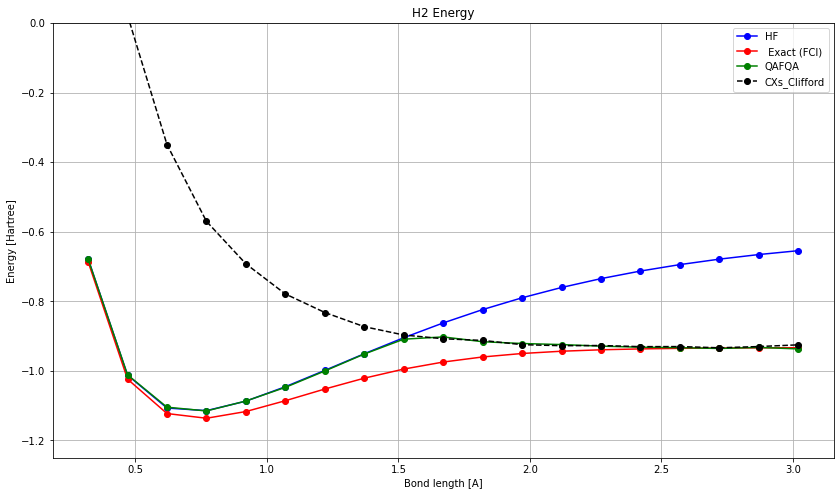

In [17]:
plt.figure(figsize=(14, 8))
plt.plot(list(mol_configs.keys()), [val[0].hf_energy for val in mol_configs.values()], 'o-', color="blue", label='HF')
plt.plot(list(mol_configs.keys()), [val[0].fci_energy for val in mol_configs.values()], 'o-', color="red", label=' Exact (FCI)')
plt.plot(list(mol_configs.keys()), [val[2] for val in mol_configs.values()], 'o-', color="green", label='QAFQA')
plt.plot(list(mol_configs.keys()), [val[2] for val in mol_configs_2.values()], 'o--', color="black", label='CXs_Clifford')
plt.ylim(-1.25, 0)
plt.grid()
plt.xlabel('Bond length [A]')
plt.ylabel('Energy [Hartree]')
plt.legend()
plt.title('H2 Energy')
plt.savefig('VQE_H2.png')

### References

Ravi, G., Gokhale, P., Ding, Y., Kirby, W., Smith, K., Baker, J., Love, P., Hoffmann, H., Brown, K., & Chong, F.. (2022). CAFQA: Clifford Ansatz For Quantum Accuracy.

]A. Peruzzo, J. McClean, P. Shadbolt, M.-H. Yung, X.-Q. Zhou, P.J. Love, A. Aspuru-Guzik, J.L. O’Brien, A variational eigenvalue solver on a photonic quantum processor, Nature Communications. 5 (2014).

Tkachenko, N., Sud, J., Zhang, Y., Tretiak, S., Anisimov, P., Arrasmith, A., Coles, P., Cincio, L. and Dub, P., 2021. Correlation-Informed Permutation of Qubits for Reducing Ansatz Depth in the Variational Quantum Eigensolver. PRX Quantum, 2(2).

McArdle, S., Endo, S., Aspuru-Guzik, A., Benjamin, S., & Yuan, X. (2020). Quantum computational chemistry. Reviews of Modern Physics, 92(1).

Qiskit documentation

Braket SDK documentation

OpenFermion documentation